In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis of the stock market with python

We will try to replicate the ITRAC algorithm in order to outperform the S&P 500.

## Getting data from an API

In [53]:
import pandas as pd 
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import time  
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import seaborn as sns
from scipy import interpolate
import itrac_grid
from itrac_grid import Grid, MultipleGrid, ProportionGrid
import threading

from utils import *

In [23]:
API_KEY = 'MDT9LRDR9TIZGJLH'
symbol = 'SPY'
ts = TimeSeries(key=API_KEY, output_format='pandas')
data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')
display(data.head())

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2021-09-03,451.98,453.63,451.550,453.08,47234364.0
2021-09-02,453.32,454.05,451.910,453.19,42830867.0
2021-09-01,452.56,453.11,451.545,451.80,48721378.0
2021-08-31,452.13,452.49,450.920,451.56,59300213.0
2021-08-30,450.97,453.07,450.710,452.23,48357355.0


## Plotting a trace

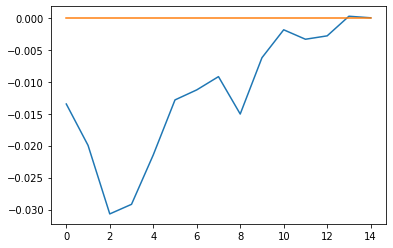

In [24]:
# Plot the closing positions 
num_of_days = 15
close = data['4. close'].to_numpy()
y = close[0:num_of_days]

y = np.flip(y,0) # The first element on data is the last day. We have to flip the array

y = y/y[-1]-1

plt.plot(y)

#Plot the 0% line
plt.plot(np.zeros(num_of_days), '-')

#plt.title('Trace of the last 60 days of ' + stock)
plt.show()

## Plotting multiple traces

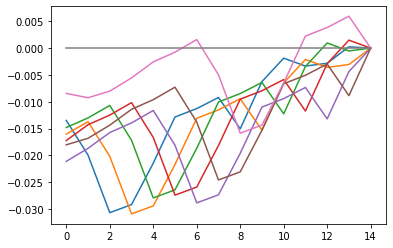

In [25]:
# Plot multiple traces
num_of_traces = 7
for idx in range(0,num_of_traces):
  y = close[idx:num_of_days+idx]
  y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
  y = y/y[-1]-1
  plt.plot(y)

# Plot the 0% line
plt.plot(np.zeros(num_of_days), '-')

# Details
plt.show()


## Splitting the dataset



In [26]:
#not used
X_test, X_validation, X_train = split(close)

print(len(X_train), len(X_validation), len(X_test))

3847 824 825
5496
3847 825 825


## EDA

Now we explore the absolute value of the returns

0.008120497770791702 0.009384024216551578


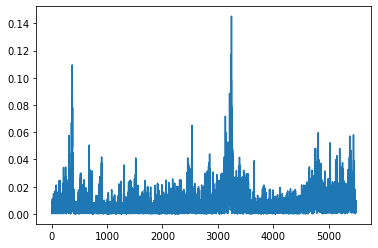

In [28]:
v = np.abs(get_returns(close[:])-1)

plt.plot(v)
print(np.mean(v), np.std(v))

## New Model Test


In [29]:
ponderation = np.array([1, 0, 0])
#grid =  MultipleGrid(7, 7, trace_size=7, num_of_grids=3,operation_type='W-L', grid_type='wins', ponderation=ponderation)
grid =  Grid(60, 60, trace_size=60, grid_type='wins')

#grid = Grid(15,15, trace_size=15, interpolation=False)
grid.train(close[365:], eliminate_noise_thold=0.018)
#img = grid.binary_image()
#img

y = close[0:grid.trace_size]
y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
todays_trace = y/y[-1]-1

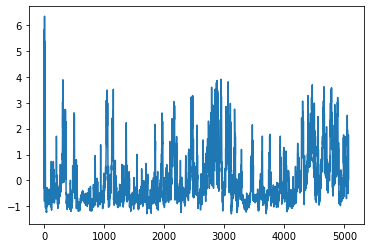

In [30]:

#ponderation = 1
scores = np.array(grid.predictions_from_ltraces(grid.train_traces))[:,0]
mean = np.mean(scores)
std = np.std(scores)
scores = (scores - mean)/std
plt.plot(scores)

X = X_validation[:365 + grid.trace_size]
ltraces = labeled_traces_from_array(X, grid.trace_size)
pred = np.array(grid.predictions_from_ltraces(ltraces))

mask0 = pred[:,2] == 0
mask1 = pred[:,2] == 1

red = pred[mask0]
green = pred[mask1]

up_thold =  grid.get_mean() + 0.4*grid.get_std()
down_thold = grid.get_mean() - 0.4*grid.get_std()



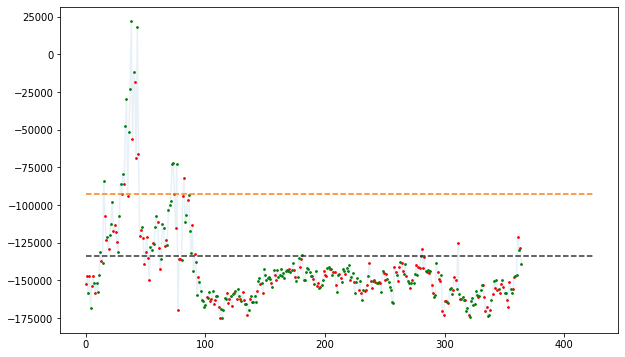

311 predictions out of 365 possible. Accuracy = 45.34%
20 above threshold prediction. Accuracy = 65.00%
291 below threshold prediction. Accuracy = 43.99%
Participation = 85.21%


In [31]:
up_thold =  grid.mean + 0.4*grid.std
down_thold = grid.mean - 0.4*grid.std

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)


plt.plot(pred[:,0], alpha=0.1)
plt.plot(range(len(X)), np.ones(len(X))*up_thold, '--')
plt.plot(range(len(X)), np.ones(len(X))*down_thold, '--', color='#333333')
plt.scatter(red[:,1], red[:,0], s= 3, c='red', alpha = 1)
plt.scatter(green[:,1], green[:,0], s= 3, c='green', alpha=1)



plt.show()

correct_red = sum(red[:,0] < down_thold)
incorrect_red = sum(red[:,0] > up_thold)
correct_green = sum(green[:,0] > up_thold)
incorrect_green = sum(green[:,0] < down_thold)

number_of_predictions = correct_green+correct_red + incorrect_red + incorrect_green
accuracy = 100*(correct_red + correct_green)/number_of_predictions
total = len(green) + len(red)
print(f'{number_of_predictions} predictions out of {total} possible. Accuracy = {accuracy:.2f}%')
print(f'{incorrect_red + correct_green} above threshold prediction. Accuracy = {100*correct_green/(correct_green + incorrect_red):.2f}%'  )
print(f'{incorrect_green + correct_red} below threshold prediction. Accuracy = {100*correct_red/(correct_red + incorrect_green):.2f}%'  )
print(f'Participation = {100*number_of_predictions/total:.2f}%'  )


In [32]:
def performance_last_days(price_vector, last_n_days, grid, alpha_plus, alpha_minus, eliminate_noise_thold=0):
    pred, mean, std = itrac_grid.last_days_grid_info(price_vector, last_n_days, grid, eliminate_noise_thold)
    return itrac_grid.performance_data(pred, mean, std, alpha_plus, alpha_minus)

my_grid = Grid(7,7, trace_size=7, grid_type='wins')
info = performance_last_days(close, last_n_days=365, grid=my_grid, alpha_plus=0.4, alpha_minus=0.4, eliminate_noise_thold=0.018)
print(info)



[51.5625, 52.602739726027394, 78.43137254901961, 13.972602739726028, 41.843971631205676, 38.63013698630137]


In [ ]:
#Automatic evaluation

def experiment(trace_size, height, width, alpha_plus, alpha_minus, operation_type, grid_type, eliminate_noise_thold):
    if operation_type =='W-L':
        grid = Grid(height, width, trace_size=trace_size, grid_type=grid_type)
    else:
        grid = ProportionGrid(height, width, trace_size=trace_size, grid_type=grid_type, operation_type=operation_type)

    info = performance_last_days(close, last_n_days=365, grid=grid, alpha_plus=alpha_plus, alpha_minus=alpha_minus, eliminate_noise_thold=eliminate_noise_thold)
    parameters = [trace_size, height, width, alpha_plus, alpha_minus, operation_type, grid_type]
    
    return parameters+info


noise_tholds = [0.04, 0.06, 0.08, 0.1, 0.12]

for eliminate_noise_thold in noise_tholds: 
    save_path = 'results_eliminate_noise_' + str(eliminate_noise_thold)
    results = []
    trace_sizes = [7, 15, 30, 60]
    operations = ['W/L', 'W-L', 'T/L', 'W/T']
    grid_types = ['wins', 'earnings']
    alphas = [0.4, 0.8, 1.2, 1.6]

    #experiments
    parameters = [[trace_size, trace_size, trace_size, alpha, alpha, operation_type, grid_type, eliminate_noise_thold] for trace_size in trace_sizes for alpha in alphas for operation_type in operations for grid_type in grid_types]

    def append_result(trace_size, height, width, alpha_plus, alpha_minus, operation_type, grid_type, eliminate_noise_thold):
        result = experiment(trace_size, height, width, alpha_plus, alpha_minus, operation_type, grid_type, eliminate_noise_thold)
        results.append(result)
        
    threads = []
    for p in parameters:
        t = threading.Thread(target=append_result, args=p)
        threads.append(t)
        t.start()

    for thread in threads:
        thread.join()

    print('finished')
    
    summary = []
    for exp in results:
      resumen = '('
      for i in range(7):
        resumen += str(exp[i]) + ','
      resumen = resumen[:-1] + ')'
      summary.append(resumen)

    df2 = pd.DataFrame(summary, columns=['summary'])
    df = pd.DataFrame(results, columns = ['trace_size', 'height', 'width', 'alpha_plus', 'alpha_minus', 'operation_type', 'grid_type','accuracy', 'participation', 'acc_above', 'part_above', 'acc_below', 'part_below'])
    df = df.sort_values(by='accuracy', ascending=False)
    df.to_csv('all_results_noNoise.csv')
    ans = pd.concat([df2, df], axis=1, join="inner")
    #ans['criteria']  = (2*df['part_above'] + df['acc_above'])/2
    ans['criteria']  = 0.01*(2*df['acc_above'] - 100)*df['part_above']*0.008*30*10000
    ans = ans.sort_values(by='criteria', ascending=False)
    
    
    
    ans.to_csv(save_path)
    



day 0
day 1
day 2
day 3
day 4
day 5
day 0day
 6
day day7 1
day

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



 
day2
day 8 3

dayday 4
day 9
 day 5
day10day
  day60
day 1
day 2
day 3
day  11

day4day 7 

day12 5
day day8 
day6 
day
9
 7
day day 1013

dayday day8
  11day
14day
  12day9 15
day 16
day
day
 day17
day   13
day 14
day 15
day 16
day10 18
day 19

day 11
day 12
day 13
day17day 14
day 
day 1820 15


dayday 19
day 20
dayday   21
day 2216
21
day 17
day 18
day 19
day 20
dayday  
23day 22

day 21
day 22day
23day 23
day 24
day 25
dayday  0 

26day 
24day
24
day 25
day 26
day 1 27
dayday
 25
daydayday 26
day 27
day 28
   2
day 3
day 27day28
 429

day
 day 30dayday 28

dayday 29 2931

day 32
day 33
day 
 34daydayday  030
day 35

 day
day5
 day 31130day 0


 
day 31
dayday 6day 
day 2dayday 7
 1
32

 36day32
day
day 33
dayday day 34day
0day    
8
 day37 35333
2dayday
dayday  
 3834

9
day 10
day 11
day 12
day day 36

day1 day 13day 
day
day
37
3  
 39day4day35 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




day 38
day 39
day 40
14

 2
day 5
daydaydayday
dayday  3    404
1541day36 

41

day

day  42day37
dayday
day  42day 
 day16day5 
38
day 6
 day day 
day39
17
43 4
day
 day day446dayday
  
dayday  743
 7
0
day  40day455
day44 

18dayday

dayday
 1day  45
 468
dayday
 
dayday day   day 68day0 41192  
day
day0
46  
91day47
 

daydaydayday  
42
day 43
day 44
day 45
day 
47day
2day
  48 day
 day1 day20 9

 10day3
day48day


  day
day49

  day7 3
46 
4day 2dayday10dayday
 
dayday
  50
 day21day 
11  3
day
dayday 51
day 52
day 53
day 54
day8 5
 day
124
55day49day
 

  day 9
day 10
day 11
dayday  11
22
6
13 
 day 12
447day56daydayday 

 7day
 day 5
23
 50
daydaydayday
dayday0
day  14 13


day  48 day dayday 
0
day 1
day day 0
day day 1
day5day  15 6

day 7
day day 18 
day214 4924
518


day
dayday day 57day

  50 15day62
day 7
day 8
day9  16

day
day 17
day 18
day 19
12
day  
52dayday 9
day 10
day 11
day 12
day  
 day2558day20

day
 day3 day1653day
 day  
dayday day13
 
59dayday 
day    20 0
da

In [12]:
summary = []
for exp in results:
  resumen = '('
  for i in range(7):
    resumen += str(exp[i]) + ','
  resumen = resumen[:-1] + ')'
  summary.append(resumen)

df2 = pd.DataFrame(summary, columns=['summary'])
print(df2)
df = pd.DataFrame(results, columns = ['trace_size', 'height', 'width', 'alpha_plus', 'alpha_minus', 'operation_type', 'grid_type','accuracy', 'participation', 'acc_above', 'part_above', 'acc_below', 'part_below'])
df = df.sort_values(by='accuracy', ascending=False)
df.to_csv('all_results_noNoise.csv')
ans = pd.concat([df2, df], axis=1, join="inner")
#ans['criteria']  = (2*df['part_above'] + df['acc_above'])/2
ans['criteria']  = 0.01*(2*df['acc_above'] - 100)*df['part_above']*0.008*30*10000
ans = ans.sort_values(by='criteria', ascending=False)

ans[['summary','accuracy', 'participation', 'acc_above', 'part_above', 'criteria']]


day 16
day 17
day 60
day 61
 day 59dayday 76
 21day 19

day 10
16day 23
day 24
daydaydaydayday   dayday day15day24
day 25
day 26
25day dayday

  day62
day 63
27   
6026
20day  0
day10
day 34
day 64
day 65
dayday 10
day 1
 day 27
day 28
day 29
day 30
day 31
day 32

day 28
day 29
day 25
day 261111day 33
day
 18

day day 0
day
day 27
day 28
day 29
day 30
day  
12 77
day3016

 day31 6166day
day   day
 34dayday 1
 
day17 


day67
 11day 2
day 3
day 4
dayday 22
day 23
 day
78 dayday
 daydayday11
day 12
   2452731
day
day
12
 
 13


 68 12
day 13
day 14
day 6
day18day 25
day 26
1935day


day 36
day 37
day 38
day 39
 35 17
day 28
day day 2
day 

dayday 13
day 32daydaydayday29 3

daydayday  19day
32dayday 15
day 16
day 17
dayday   33
day 34
day 357 7962day
day 
 69
day18
  36
day 37

day 33
day 
 day day 14
day 
151318 36
27
day
 day 
day 40daydayday 1470

 day 2821day 14
 
 dayday 
12
day day71 
2019
  dayday
19day
63day 
341615



day
 day daydayday15
day 16
day 17
day 18
day day4  20
2220day

,summary,accuracy,participation,acc_above,part_above,criteria


35day  
82 
26
day34
day 35
day 36
day 37

52day 20

day76day
day 7
day 8
dayday day 15 
daydayday 32
day 33
day 34
58 9
day 10
 dayday
day42 
day 
   51
day 52
   22 daydayday31 

 83day 43
11
 day38
day 53
day 541414
day 15

 
day dayday2123day 84 
2734 53

day day day 45
77
day 78
54

day 16

day 24
dayday35
dayday 1
16dayday
day 35
 day 55
 39
day 40
day 41
54 
36
day 37
 36day day 422 41day 059
day
day 
36 day 46
day 47


day 26
3
day22
day 23

dayday 79
93
day 17

day 60
 38
 15
day 16
daydaydaydayday 94
day 55
day 56 day 25
 17
dayday 2644day 9
dayday 28
day 29
85
day


day day 18
dayday 27
day 56
day day day 10
86dayday  48
day 49
day 50
day 51
day 1dayday
day

day dayday39 37daydayday 3719day
day 32day dayday  4
dayday
 18
day 19
day 20
day 11day 
 27day 2
     

 61 

57
 45day 
24day  
 30  9543

21
31712day day57dayday20
day day
40day 44
day 45


52 day 12
day


38day42
    
5dayday288031 



day
day 39
day 40
 day3
 38
day 39
day 40
dayday 2855
day 56
day 5746day 62daydayd

## PANDAS MAGIC

In [12]:
for noise_thold in [0 + 0.002*i for i in range(11)] + [0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]:
    sufix = str(noise_thold).replace('.', '_')[:min(len(str(noise_thold)), 5)]
    path = "results_eliminate_noise_"+ sufix + ".csv"
    
    print(path)
    dataframe2 = pd.read_csv(path)
    dataframe2['criteria'] = 0.01*dataframe2['part_above']* (2*0.01*dataframe2['acc_above']-1)
    dataframe2['criteria3'] = dataframe2['part_above'] + 10*dataframe2['acc_above']
    dataframe2['proyected_part_above'] = (5*dataframe2['part_above']).map(lambda x: min(x,100))
    dataframe2['criteria2'] = 0.01*dataframe2['proyected_part_above']* (2*0.01*dataframe2['acc_above']-1)
    #dataframe2 = dataframe2[['summary','trace_size', 'height', 'width', 'alpha_plus', 'alpha_minus', 'operation_type', 'grid_type','accuracy', 'participation', 'acc_above', 'part_above', 'acc_below', 'part_below', 'criteria', 'criteria2']]
    dataframe2 = dataframe2[dataframe2['part_above'] > 10].sort_values(by='acc_above', ascending=False)
    #print(dataframe2[['summary','acc_above', 'part_above', 'criteria', 'criteria2', 'proyected_part_above']][:5])
    dataframe2.to_csv('new_experiments/filtered_'+path , index=False)
    

day day 66
day 67
day 68
day day 8
day 9
day 104632

day 24
day 25
dayday 
day 38
day 48
day 49
 10050  day61
 63
dayday33
61
day
28day 

 dayday
day day day35
day7day 6 
23
day 24

   64 11
dayday45
26
day 46

day16 

day 27
day 28
day 39day
day  50
day 51 
65
45day69
day 7
day 8day day 40
day 41
day 42
day 43
4736
 2929 51
day 52
day 53
dayday 33

101day dayday day



47dayday 
day47 88  24
dayday
  
17
day 18
day 19
day 20
day 21

52 dayday 5455day  48
34
dayday  
day day
62
dayday
 43 25 daydayday
 day 25
28day3762 day 12 30
 
90
day 91

dayday
30day dayday dayday day 92
day 93
day 94
 
day 22
day 23
48
day 49
day 50
56 
 
day89day 
 26day13
66 3135 day31



102 


day 0daydayday dayday46
day day
 674463518 32


 daydayday26
57
 70
day 71
day 72
day 73
day
day 24
day

 68
day day
  29
34
 
dayday results_eliminate_noise_0_0.csv
 daydayday 27 day 
1day
10349   52
 

 33694836
 55dayday  95

day 49
day 50
dayday
 3230day63day 90
53
9
dayday dayday 47dayday
   
9127

day28day dayday14

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



89
138day  37 79

day 30 
 day77
dayday65 
11
day 12
day dayday 

dayday100day   133dayday  

  7272
64 
 dayday
38day35

 101
97
day 98
day68 1379dayday
 7371   92
day
dayday

day day


day  day6378  day
 

 28 13973 

43day
819980
90dayday day

127 day4890
day
day  9939 

 dayday101dayday
134
8
day74 78104
day 
dayday81dayday42
dayday

 day 0

    day   day
 669336dayday102day
6980 44
day 45
day 46
   dayday10531

 day 100
day 101
day 102
day 103




day
dayday100

day0

 9965

day 

 67 day91day
day dayday day
day  1
135 day 14043 72 day64 day

75128 
 dayday 47
day 65
day 66
day7432 day
day day1day40
day 76
day 77
day 78 
day  day101
day 136
day 137
day 
 day

day 
day 
9 82
14
dayday 10
102day10679 
dayday 91 
day
  
day
10482 dayday70
day 71
day 72
  day92 day 107
day 108
day 109
dayday33 81
 37dayday 79129210367
75
 day day

  
day 11day 100day79
102
day
68day 48
day 49
  
94 dayday 50
29
92day


day 


dayday73 dayday 
141day 38
day2
 day  
 
  
83day 39
682
69 day34
day82 101


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



80day15460day 
 day 70day121 
day 81
day 82
day 83
dayday 63day
day70
day 

 

153
7058153  155


52day day
dayday
 daydaydayday day day dayday 134
day84  52
day 114
 71
day176175 174 152 
74day 61
73
 
63149
154day 85
day 86 

 206
day 207

dayday

day 62
day 63

day 129
day67
  139
day 140



 day  day 63

day156
 50
  56day

day 64
daydaydaydayday 
173
day 
214 61205day5768daydayday day   162
 84
day 85
day 86
day dayday 

 day174
daydayday87dayday146153 day168day183
 71day  

day  

153 68day
 
 219day53

44
day
 day day75
day64 day  
5176107 day 141 20864day day 15664day daydayday 135107day
6575

 
53
122115
 7372day 88
 

day day
   177
175


day147

 
day 
day
 184day57
 

day  
day dayday
dayday130154day 136
63154day

day
 65
  
173 daydayday69dayday155day 154
day 155
day 156

  day 
  

day169day59day
74176  day 178
day 179
day 180
day 181
day163

123206day155dayday
 

  
day6668dayday 85day89  

   

day
day 86
day 87
day
 73 209
day 210
day 211
day 212
daydayday   220dayday5

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



 
122day84  day115day  
day day 
 69213 76152  236224day163day
 
181 186191
day57 134
 
  97dayday day167day168
 
84
day
 day162 
161 
day   day
day day

50 
7573191 161  186189day61day
80

8180  day
day  
day
170
 22085 day 193day71200

96
15960


166 day 140192day 135
146
day 

day8595 173

 
 dayday71
day
181day


day 167
day 168
day
dayday85day11663 

187
day 175day 
day 
81 day

74dayday 80

 153day70day 

123day85
day80
  day
dayday day201day114dayday  
 
day 
5975 
184 169

 

 day
  dayday162day141
day85  23786 77dayday89dayday
169
 214 daydayday 


day61day  day163
     day
187 86day96   176171
day225

81
  
day
 
day6271

day 
8616216418281 
dayday 


86day 86dayday 177
day 178
day 179
day day
58 

 day 124day


72day
day
day98
14782day day 
182  180day
170dayday
76192 day202day
 81daydayday190
day 191
day 192
day 193
day


 226 160   day16364   142 dayday238
day117 
day62221 
dayday
7216578
 
daydayday 
  59
day 60
day 61
dayday


daydayday 170
 215  63 day97day 203
day 204



KeyboardInterrupt




189
 day 
 daydayday87dayday
84158   208dayday

day 204
day 205
day 206
day 207

 day 113
day 11499  
 dayday 120186 dayday178   day day213
day187198240
200  

13382day  
 
184174154
188 179 
 96 79
dayday 


dayday   96 8575day208
93 day 
 90
day
161 97
 100186203
232

103dayday
day197
day179day


  day
day95 256

 88day 149day day76105
 
 
102 
 
day 89
209
day211day 209

day
75day188
dayday87
199 180
day130day
day
155 

day 190
 day
 
243day
day86day

 214
day  day day 
day dayday day179day220  
day 19924192 


day day18196dayday

85dayday
 day  

 189115 day189day88day
day
day 77
day
208 
  150day 162 
dayday
 
day 182
day 183
day  dayday 
day
day 209
day 210
day97175
  
day day159daydayday
    
day 98
day 99
day163
day 164
103
80
day 81
day 82
168 dayday  
day
day204185211day104day 94 dayday 215
 day 100
day 101
day 102
day244
210
83 18790    



dayday 9787day day100101dayday  165

    121131
  
109 

day96
106 97day187
191
201  89 dayday242103dayday86day200
210
 257 
day 
91
da

In [ ]:
metrics = ['accuracy', 'participation', 'criteria', 'acc_above', 'part_above', 'acc_below', 'part_below', 'criteria2']
dataframe1 = pd.read_csv("new_experiments/filtered_results_eliminate_noise_0_0.csv")[:15]
changes = pd.DataFrame()
#+[0.14, 0.16, 0.18, 0.2]
for noise_thold in [0 + 0.002*i for i in range(11)]:
    sufix = str(noise_thold).replace('.', '_')[:min(len(str(noise_thold)), 5)]
    path = "new_experiments/filtered_results_eliminate_noise_"+ sufix + ".csv"
    dataframe2 = pd.read_csv(path)[:15]
    series = 100*(dataframe2[metrics]/dataframe1[metrics]-1).replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna().mean()
    changes[ str(noise_thold)[:min(len(str(noise_thold)), 5)]] = series

changes.transpose()[['accuracy', 'acc_above']].plot(grid=True)
changes.transpose()[['participation', 'part_above']].plot(grid=True)
changes.transpose()[['criteria']].plot(grid=True)
changes.transpose()[['criteria2']].plot(grid=True, color='red')




In [ ]:
metrics = ['accuracy', 'participation', 'criteria', 'acc_above', 'part_above', 'acc_below', 'part_below', 'criteria2']
dataframe1 = pd.read_csv("new_experiments/filtered_results_eliminate_noise_0_0.csv")[:10]
changes = pd.DataFrame()
#+[0.14, 0.16, 0.18, 0.2]
for noise_thold in [0 + 0.002*i for i in range(11)]+[0.14, 0.16, 0.18, 0.2]:
    sufix = str(noise_thold).replace('.', '_')[:min(len(str(noise_thold)), 5)]
    path = "new_experiments/filtered_results_eliminate_noise_"+ sufix + ".csv"
    dataframe2 = pd.read_csv(path)[:10]
    series = 100*(dataframe2[metrics]/dataframe1[metrics]-1).replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna().mean()
    changes[ str(noise_thold)[:min(len(str(noise_thold)), 5)]] = series

    
#Plotting

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.suptitle('Elimination of noise improvment with more threholds', fontsize=16)
changes.transpose()[['accuracy', 'acc_above', 'acc_below']].plot(grid=True, ax = axes[0,0])
changes.transpose()[['participation', 'part_above', 'part_below']].plot(grid=True,  ax = axes[0,1])
changes.transpose()[['criteria']].plot(grid=True,  ax = axes[1,0])
changes.transpose()[['criteria2']].plot(grid=True, color='red',  ax = axes[1,1])




In [ ]:
last_year_criteria = 1*(2*0.58-1)
last_year_criteria2 = last_year_criteria + 0.58*0.001

print(last_year_criteria, last_year_criteria2)

 
205 


193day125 264
205 
  day
170 
154dayday208day day
day 95

183 day101193 
day 214
103 dayday

  91
day
 
 

216day 88
day dayday  day 
109
day 254
dayday113  84
80dayday
 
  201 239
day 88
day 89
day 90
day
141  
22684
day
day day
day   
 day 248155day191265day
110day 

dayday 126
day 12789217 192day94185 day 101day
day98


206day96

10210168
 day 215100211 120 day
day

221 194
day 195
day 196
day 197
day day 81

day
99
day 100
day216 
  day
day 255


192
91




dayday 
85dayday
 171day 
113108177 240
day 241
day 242
day96daydaydayday day day110140 
  day  day


102
day
 16585 

243
day  192
  
 121101
day 102
daydayday69day
 dayday   dayday 97
 
198day 207186day 141
244110 161
dayday

 day
82102 
day193day 227day dayday198day day
 dayday
 day
day 
day

 217
day 218
day 219
day114 dayday70 172
day
194  
 

202day
dayday 114  
99
day 
 day
142day 
 day184
day111 dayday  day 218day
day 209dayday111212216 103   dayday
266day day 101105
 199
128dayday208
122
8686  day   


98
10322

In [ ]:
[0.1835616438356167, '0.16'], [0.1835616438356167, '0.18'], [0.1835616438356167, '0.2']]

In [ ]:
testdf = pd.read_csv("new_experiments/filtered_results_eliminate_noise_0_018.csv")
testdf = testdf.sort_values(by='criteria2', ascending=False)
print(testdf[['summary','acc_above', 'part_above', 'criteria', 'criteria2']])

 


day
dayday125day22099231215
 
 day
223102155dayday 109
day 110
 

  206day 109
day 110
day 111
day  277206115day115dayday209230day 191120day 262
day 263
day 264
dayday  183  day 
110104199day
dayday95244

 120dayday 209day 124day 265
day 266
 
day


 day
day 100

216
  112123

day117240 day


day 221
day 222
day102day 245

 day 

 day
dayday 106day278dayday 

day135156

day
 172

dayday90dayday
 135
day 121
267229
day 230
daydayday 107
day 108
  207
192day  day day
dayday 

day 121
day 122

 
 
217  day dayday 223217
  day 172
day 173
day 174
dayday116121
  day 111
 105 day 
day

day188  199day 

day
day 119  231 96175
day246day118
199  209day 155dayday 136
day 137
day 138 
 day

dayday97210236200116 126
 day day80
106dayday
175day122111
   day103day 109
day 110
 day
 daydayday



115
daydaydayday
 dayday
224  216    


231day 112
day 113
day 114
day  267184day 208

 103   dayday
 

day112
123210117206day124
day 125
day 126
day    

193189
  
 173day279 dayday156

day113207136day 9